In [349]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
from collections import Counter
import pickle

## X matrix (TCR expression)

In [410]:
TRAB = "TRA"
TCELL_TYPE = "CD4+CD45RA-" #"CD8+"

df = pd.read_csv("NarcolepsyTargetedSequencing/MAIN_{}_USAGE_CLEANED.csv".format(TRAB))#{}_cleaned.csv".format(TRAB))

In [411]:
# DBID=14287 has two rows
usage_df = df[df['cell_type'] == TCELL_TYPE].fillna(0)

In [412]:
# drop all non-usage columns except DBID and SEQ (lane)
tcr_columns = [x for x in usage_df.columns if x.startswith("TR")]
#usage_df = usage_df.drop(labels=['BC', 'CELLTYPE', 'DBID2', 'CHAIN'], axis=1)

In [413]:
usage_df = usage_df.rename(columns={"DbID":"DBID"})

In [414]:
rename_dict = dict()
for col_name in tcr_columns:
    family = col_name.split("*")[0]
    family = family.split("|")[0]
    prefix = family[:4] # TRBJ, TRBV
    suffix = family[4:]
    if suffix[0] == "0": # get rid of the 0
        suffix = suffix[1:]
    cleaned = prefix + suffix
    rename_dict[col_name] = cleaned

In [415]:
usage_df = usage_df.rename(columns=rename_dict)

In [416]:
second_rename_dict = {"TRAV2-1":"TRAV2", "TRAV14":"TRAV14/DV4", "TRAV36":"TRAV36/DV7", "TRAV38-2":"TRAV38-2/DV8",  "TRAV29":"TRAV29/DV5", "TRAV23":"TRAV23/DV6"}

In [417]:
usage_df = usage_df.rename(columns=second_rename_dict)

In [418]:
"""Filter out pseudogenes and non-functional genes"""
valid_TCR_genes = set()
with open("valid_TCR_genes.txt", "r") as f:
    for line in f:
        valid_TCR_genes.add(line.strip())

In [419]:
pseudogene_columns = []
for gene_name in rename_dict:
    cleaned_name = rename_dict[gene_name]
    if cleaned_name in second_rename_dict:
        cleaned_name = second_rename_dict[cleaned_name]
    if cleaned_name not in valid_TCR_genes:
        pseudogene_columns.append(cleaned_name)

In [420]:
pseudogene_columns

['TRAV35', 'TRAJ15', 'TRAJ8', 'TRAJ15']

In [421]:
"""Drop pseudo/nonfunctional gene columns"""
usage_df = usage_df.drop(pseudogene_columns, axis=1)

In [422]:
# because we mapped all family subtypes to the family name, now we have duplicate columns that we should merge
usage_df = usage_df.groupby(usage_df.columns, axis=1).sum()

In [423]:
usage_df = usage_df.groupby(usage_df.columns, axis=1).sum()

In [424]:
usage_df = usage_df.reindex(sorted(usage_df.columns), axis=1)

In [425]:
pickle.dump(usage_df, open("NarcolepsyTargetedSequencing/{}_usage_df.pkl".format(TRAB), "wb"))

In [426]:
tcr_columns = [x for x in usage_df.columns if x.startswith("TR")]

In [427]:
usage_df_long = usage_df[['DBID']+tcr_columns].melt('DBID', var_name='family', value_name='usage_ratio')

In [428]:
### PLOT EACH TCR SEGMENT USAGE

# f, ax = plt.subplots(figsize=(5,20))
# sns.boxplot(y="family", x="usage_ratio", data=usage_df_long)
# plt.xlim((0,0.5))
# plt.title("{} Protein Coding and Functional Genes".format(TRAB))

In [429]:
usage_df = pd.get_dummies(usage_df, columns=['SEQ']) # encode SEQ lane as dummy variable

In [430]:
usage_df.to_csv("TargSeq_{}_all_df.csv".format(TRAB), index=None)

### Combine TRA and TRB dfs (deprecated)

In [431]:
# TRA_usage_df = pickle.load(open("NarcolepsyTargetedSequencing/TRA_usage_df.pkl", "rb"))
# TRB_usage_df = pickle.load(open("NarcolepsyTargetedSequencing/TRB_usage_df.pkl", "rb"))
# TRAB_usage_df = pd.merge(TRA_usage_df, TRB_usage_df, on="DBID", how="outer")
# TRAB_usage_df = TRAB_usage_df.drop_duplicates(subset=["DBID"])
# TRAB_usage_df
# TRAB_usage_df.to_csv("TargSeq_all_TCR_df.csv")

In [432]:
TRAB_usage_df = usage_df.drop_duplicates(subset=["DBID"]).fillna(0)

## With Aditya's new file 602 and 301 genotypes are included. Temp don't need to run below code.

## Y matrix (genotype and phenotype data)

In [433]:
geno_df = pd.read_csv("NarcolepsyTargetedSequencing/total_done_list.csv")

In [434]:
dbid_plateid_mapping = geno_df[['DBID', 'PLATEID']]

In [435]:
TRA_df = pd.read_csv("NarcolepsyTargetedSequencing/ALPHA_TCR_BASELINE_FILENAMES_NOV22_2019.csv")
TRA_allowed_DBIDs = set(TRA_df['DBID'].values)
TRB_df = pd.read_csv("NarcolepsyTargetedSequencing/BETA_TCR_BASELINE_FILENAMES_NOV22_2019.csv")
TRB_allowed_DBIDs = set(TRB_df['DBID'].values)

In [436]:
# these are all of the people we are interested in
len(TRA_allowed_DBIDs), len(TRB_allowed_DBIDs)

(182, 148)

In [437]:
if TRAB == "TRA":
    TRAB_allowed_DBIDs = TRA_allowed_DBIDs #TRA_allowed_DBIDs.union(TRB_allowed_DBIDs)
else:
    TRAB_allowed_DBIDs = TRB_allowed_DBIDs
len(TRAB_allowed_DBIDs)

182

In [438]:
geno_df = pd.read_csv("NarcolepsyTargetedSequencing/total_done_list.csv")

In [439]:
# this dataset is quite messy. a person can appear on multiple rows yet some rows could have nan values
# use forward fill and back fill to fill in missing data
geno_df = geno_df.groupby("DBID").apply(lambda x: x.ffill().bfill())

In [440]:
geno_ids = set([str(x) for x in geno_df['DBID'].values])

In [441]:
len(geno_ids)

143

In [442]:
# 44 people do not have corresponding genotypes
len(TRAB_allowed_DBIDs.difference(geno_ids))

45

In [443]:
len(TRAB_allowed_DBIDs.intersection(geno_ids))

137

In [444]:
# update allowed IDs to be the ones that we have genotype and phenotype information
TRAB_allowed_DBIDs = TRAB_allowed_DBIDs.intersection(geno_ids)

In [445]:
len(TRAB_allowed_DBIDs)

137

In [446]:
geno_df.columns

Index(['DBID', 'Name', 'PLATEID', 'Gender', 'Age', 'interval',
       'cata onset age', 'Dx', 'HCRT', '0301', '0602', 'rs1483979', 'Race',
       '# to SEQ1', 'alpha', '# to SEQ2', 'beta', 'cell type', 'Cell#',
       'Viability(%)', 'blood date', 'primers/ID', 'SEQ type', 'sent out date',
       'done date', 'note', 'vaccination', 'done by', 'Unnamed: 28'],
      dtype='object')

In [447]:
# only keep geno_df to the people who are allowed
geno_df = geno_df[geno_df['DBID'].isin(TRAB_allowed_DBIDs)]
# dropping same person duplicates
geno_df = geno_df.drop_duplicates(subset=["DBID"])
# only keep interesting columns
geno_df = geno_df[['DBID', 'PLATEID', 'Dx', 'Gender', 'Age', 'rs1483979']]
len(geno_df)

137

In [448]:
# # drop rows that dont include any of these information
# geno_df = geno_df.dropna()
# len(geno_df)

In [449]:
# map patient/control to 1/0
geno_df.loc[:,'Dx'] = geno_df['Dx'].apply(lambda x: 1 if x=='P' else 0)

In [450]:
# map M/F to 1/0
geno_df.loc[:,'Gender'] = geno_df['Dx'].apply(lambda x: 1 if x=='M' else 0)

In [451]:
# # map genotypes to 1/0
# geno_df.loc[:,"0301"] = geno_df['0301'].astype("int")
# geno_df.loc[:,"0602"] = geno_df['0602'].astype("int")

In [452]:
len(geno_df[geno_df['Dx'] == 1])/len(geno_df) # proportion of patients vs controls

0.48175182481751827

In [453]:
geno_df.loc[:,'DBID'] = geno_df['DBID'].astype(str)

In [454]:
geno_df['DBID'] = geno_df['DBID'].astype("int")

## As we have incomplete information in the 0301 and 0602 columns, do additional HLA imputation

In [455]:
hla_df = pd.read_csv("NarcolepsyTargetedSequencing/COMBINED_HLA_2019.csv")

In [456]:
hla_df = pd.merge(dbid_plateid_mapping, hla_df, on="PLATEID").drop_duplicates(subset=["DBID"]).drop("PLATEID", axis=1)

In [457]:
hla_df2 = hla_df[['DBID']].copy()

In [458]:
all_alleles = set(hla_df['HLA_DQB1_A1'].values).union(set(hla_df['HLA_DQB1_A2'].values))

In [459]:
for allele in all_alleles:
    allele_name = "HLA_DQB1*{}".format(allele)
    dosage = (hla_df['HLA_DQB1_A1'] == allele).astype("int") + (hla_df['HLA_DQB1_A2'] == allele).astype("int")
    hla_df2[allele_name] = dosage

In [460]:
# if want Dx and other meta data
hla_df3 = pd.merge(geno_df, hla_df2, on="DBID")

In [461]:
hla_df3['DBID'] = hla_df3['DBID'].astype("str")

In [462]:
hla_df3.to_csv("TargSeq_HLA_df.csv", index=None)

In [463]:
hla_df3

,DBID,PLATEID,Dx,Gender,Age,rs1483979,HLA_DQB1*06:02,HLA_DQB1*04:02,HLA_DQB1*05:02,HLA_DQB1*06:03,HLA_DQB1*06:04,HLA_DQB1*05:03,HLA_DQB1*03:03,HLA_DQB1*06:09,HLA_DQB1*02:01,HLA_DQB1*02:02,HLA_DQB1*03:01,HLA_DQB1*05:01,HLA_DQB1*03:02
0,11668,70A12,0,0,22.460274,CG,1,0,0,0,0,0,0,0,0,0,0,1,0
1,13344,50D03,1,0,52.369863,CG,1,0,0,0,0,0,0,0,0,0,0,0,1
2,13115,70B08,0,0,9.627397,GG,1,0,0,0,0,0,0,0,0,0,1,0,0
3,13120,70B09,0,0,10.183562,CG,1,0,0,0,0,0,0,0,0,0,1,0,0
4,11746,70B04,0,0,10.479452,GG,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,13008,42D11,1,0,14.701370,CG,1,0,0,0,0,0,0,0,1,0,0,0,0
121,4961,13B11,1,0,44.841096,GG,2,0,0,0,0,0,0,0,0,0,0,0,0
122,7402,16C10,1,0,40.961644,GG,1,0,0,0,0,0,1,0,0,0,0,0,0
123,13373,56E12,1,0,46.939726,GG,1,0,0,0,0,0,0,0,0,1,0,0,0


In [464]:
all_df = pd.merge(hla_df3, usage_df, on="DBID", how="inner").drop_duplicates("DBID").drop("PLATEID", axis=1)
all_df

,DBID,Dx,Gender,Age,rs1483979,HLA_DQB1*06:02,HLA_DQB1*04:02,HLA_DQB1*05:02,HLA_DQB1*06:03,HLA_DQB1*06:04,...,SEQ_HS53,SEQ_HS67,SEQ_HS78,SEQ_HS79,SEQ_HS81,SEQ_HS9,SEQ_HS96,SEQ_HS97,SEQ_HS98,SEQ_HS99
0,13344,1,0,52.369863,CG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13115,0,0,9.627397,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13124,0,0,14.169863,CG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13126,0,0,14.715068,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15688,0,0,20.572603,CC,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,16021,1,0,22.410959,NaN,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
69,4961,1,0,44.841096,GG,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,7402,1,0,40.961644,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,13373,1,0,46.939726,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [465]:
all_df.to_csv("TargSeq_{}_all_df.csv".format(TRAB), index=None)

In [466]:
all_df['HLA_DQB1*06:02'].values

array([1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1])

## J24 SNP --> usage sanity check

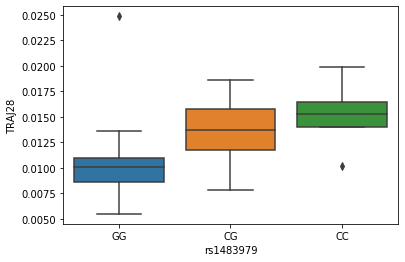

In [467]:
if TRAB == "TRA":
    j24_df = all_df[['rs1483979', 'TRAJ28']].dropna()
    #j24_df = j24_df[j24_df['TRAJ28'] < 0.08]
    j24_df['dose'] = j24_df['rs1483979'].apply(lambda s: s.count("C"))
    sns.boxplot(y="TRAJ28", x="rs1483979", data=j24_df, order=['GG', 'CG', 'CC'])

In [468]:
all_df.to_csv("TargSeq_{}_all_df.csv".format(TRAB), index=None)

In [469]:
all_df

,DBID,Dx,Gender,Age,rs1483979,HLA_DQB1*06:02,HLA_DQB1*04:02,HLA_DQB1*05:02,HLA_DQB1*06:03,HLA_DQB1*06:04,...,SEQ_HS53,SEQ_HS67,SEQ_HS78,SEQ_HS79,SEQ_HS81,SEQ_HS9,SEQ_HS96,SEQ_HS97,SEQ_HS98,SEQ_HS99
0,13344,1,0,52.369863,CG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13115,0,0,9.627397,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13124,0,0,14.169863,CG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13126,0,0,14.715068,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15688,0,0,20.572603,CC,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,16021,1,0,22.410959,NaN,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
69,4961,1,0,44.841096,GG,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,7402,1,0,40.961644,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,13373,1,0,46.939726,GG,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
